In [16]:
import h5py
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aging.organization.dataframes import get_age
from aging.organization.paths import get_experiment_grouped_files
from toolz import compose, valmap, curry, complement, groupby, keyfilter
from collections import defaultdict

In [5]:
from tqdm.auto import tqdm

In [2]:
def is_old_proc(file):
    return file.parent.name == "proc"


def has_key(key, file):
    with h5py.File(file, 'r') as h5f:
        return key in h5f

In [3]:
paths = get_experiment_grouped_files()
old_files = valmap(compose(list, curry(filter)(is_old_proc)), paths)
new_files = valmap(compose(list, curry(filter)(complement(is_old_proc))), paths)

In [57]:
# gather median poses from every animal in ontogeny

median_poses = {
    'males': defaultdict(list),
    'females': defaultdict(list),
}

for exp in ('ontogeny_males', 'ontogeny_females'):
    for age, path_list in tqdm(groupby(get_age, new_files[exp]).items()):
        for path in path_list[:6]:
            with h5py.File(path, 'r') as h5f:
                frames = h5f['frames'][:9_000]
                med_pose = np.median(np.where(frames > 3, frames, 0), axis=0)
            key = 'females' if 'females' in exp else 'males'
            median_poses[key][age].append(med_pose)

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [58]:
median_poses = valmap(curry(valmap)(np.array), median_poses)

In [59]:
joblib.dump(median_poses, '/n/scratch/users/w/wg41/median-poses.p')

In [63]:
from itertools import product

In [64]:
template = median_poses['males'][12].astype('float32')

In [65]:
list(median_poses)

['males', 'females']

In [66]:
comparison_to_template = {
    'males': {},
    'females': {},
}

for sex, pose_dict in median_poses.items():
    for age, poses in pose_dict.items():
        poses = poses.astype('float32')
        pairwise_height_diffs = []
        for i, j in product(poses, template):
            diff = j - i
            height_diff = np.median(diff[diff != 0])
            pairwise_height_diffs.append(height_diff)
        comparison_to_template[sex][age] = np.array(pairwise_height_diffs)

<Axes: ylabel='Count'>

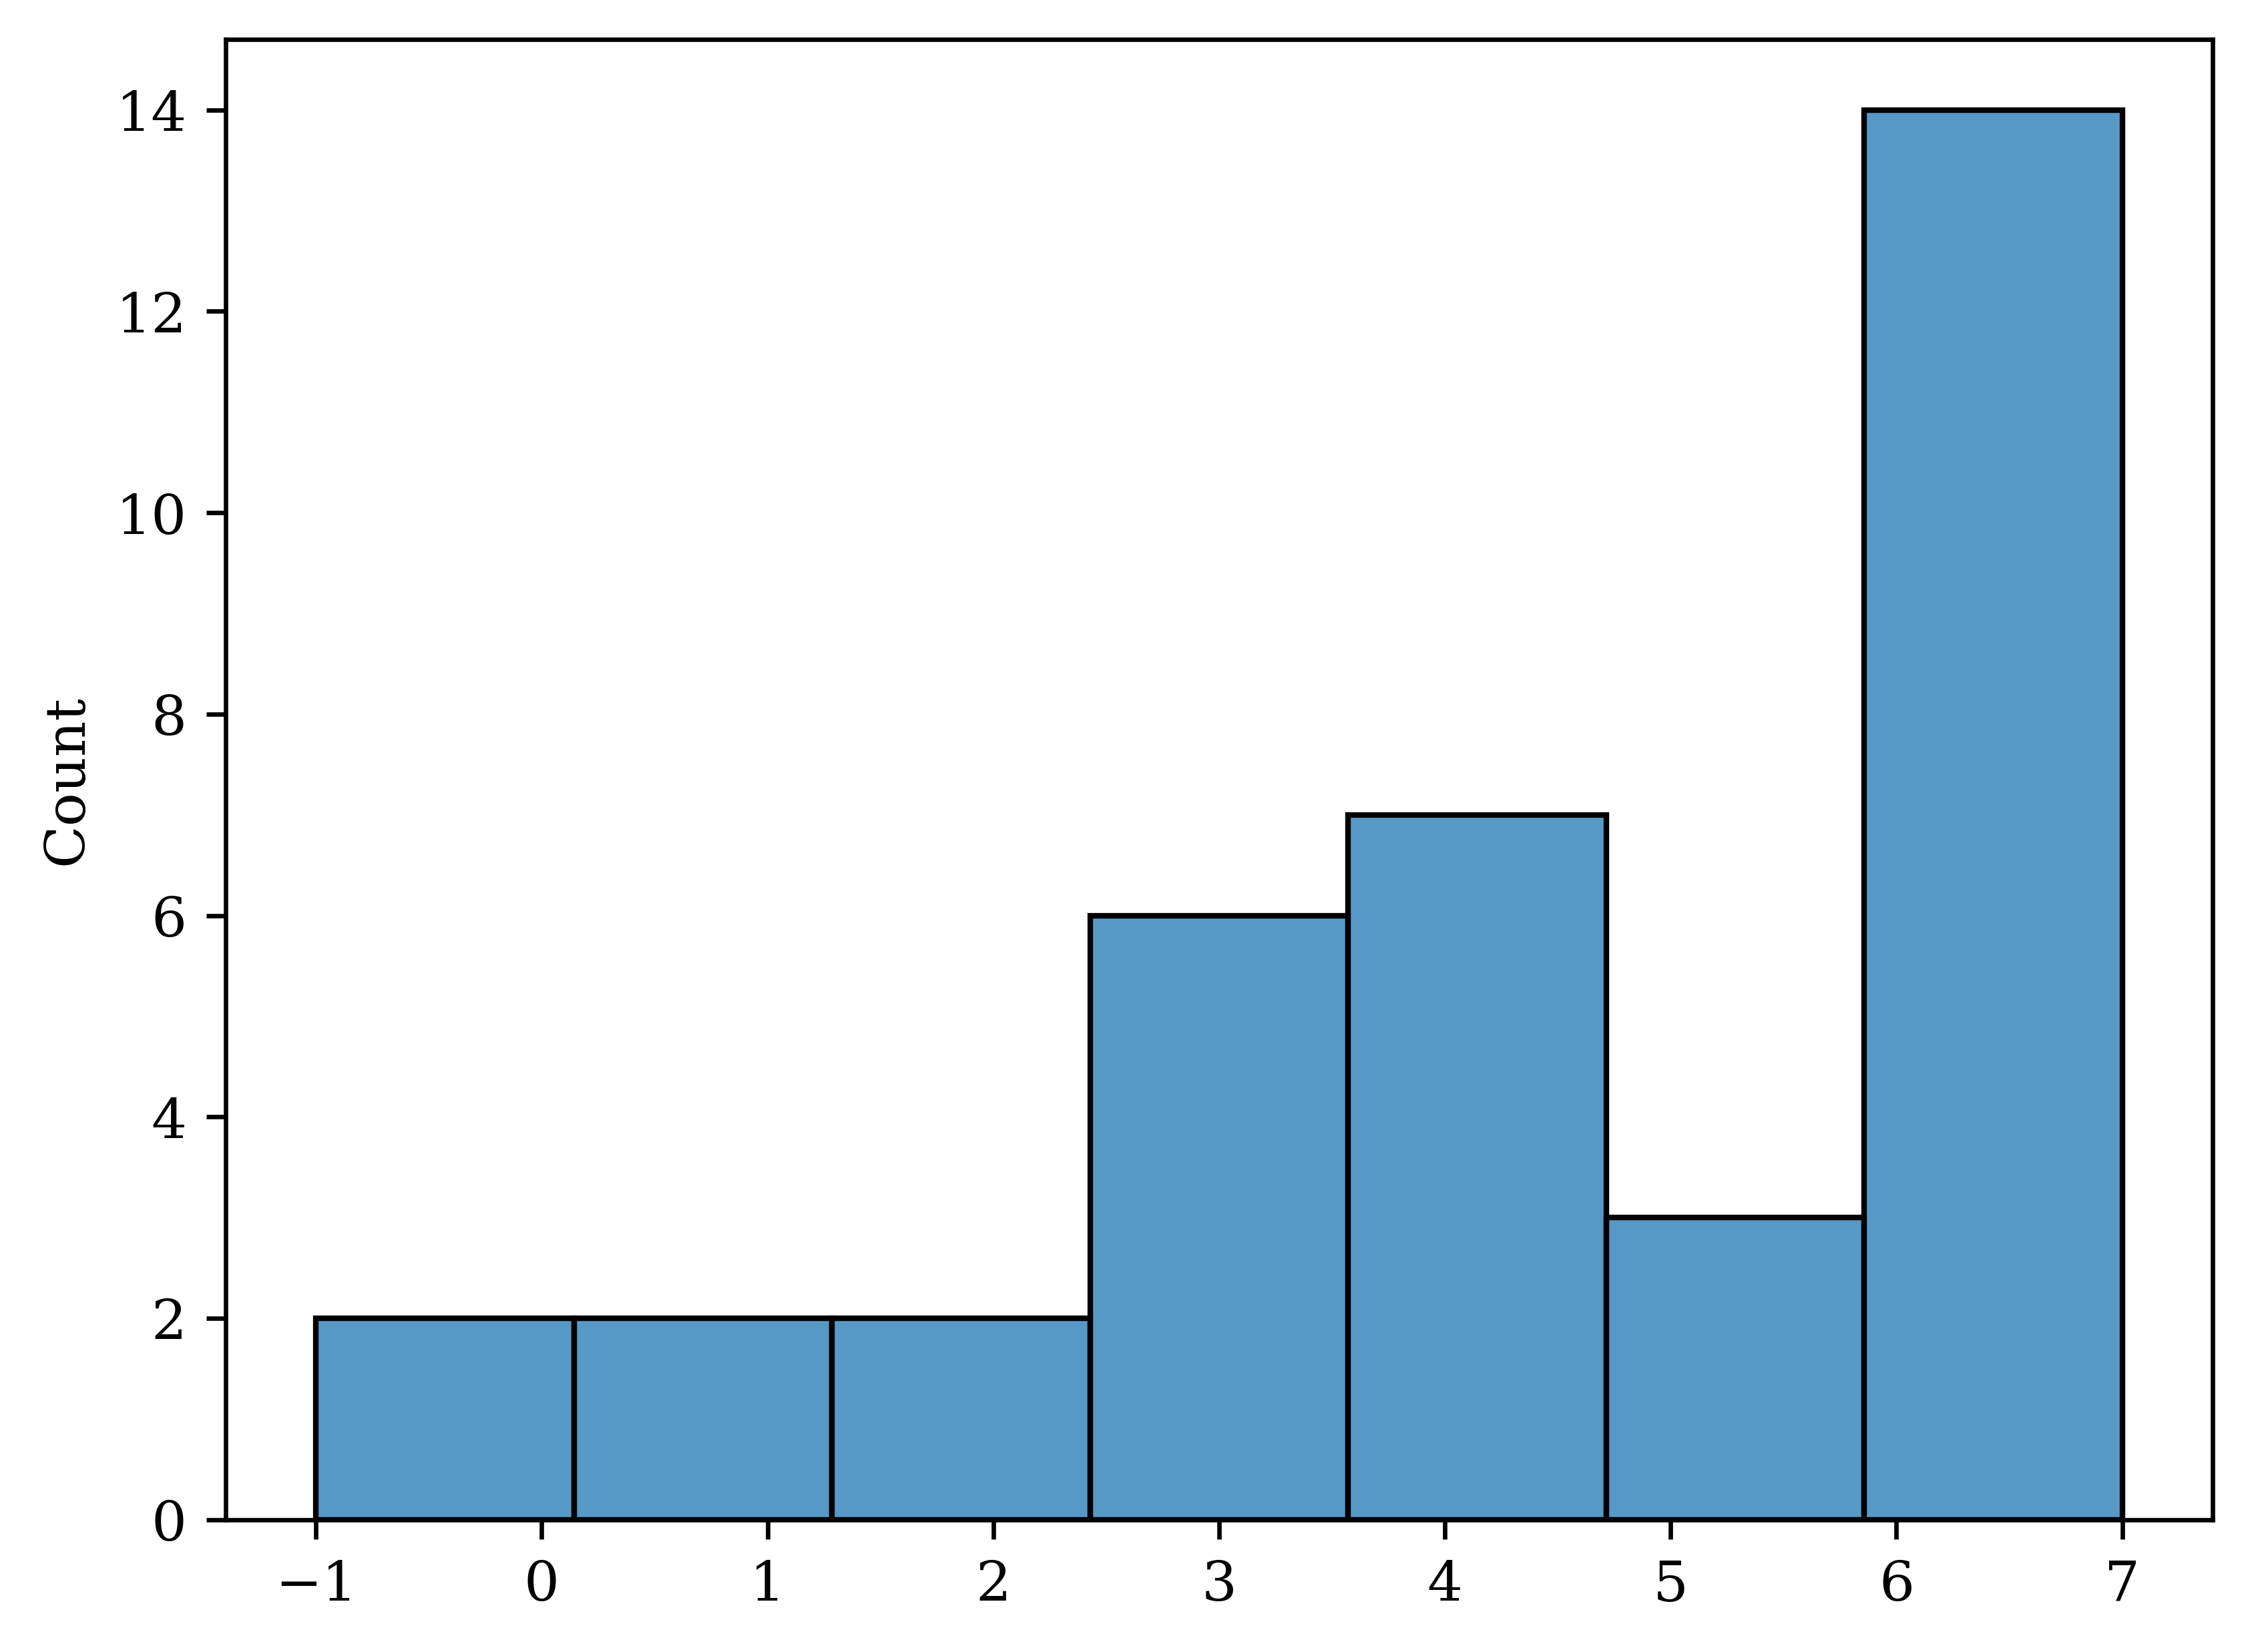

In [67]:
sns.histplot(comparison_to_template['females'][12])

## Get just template male height

In [68]:
males = groupby(get_age, new_files[exp])

path_list = males[12]
template_median_poses = []
for path in path_list:
    with h5py.File(path, 'r') as h5f:
        frames = h5f['frames'][:9_000]
        med_pose = np.median(np.where(frames > 3, frames, 0), axis=0)
    template_median_poses.append(med_pose)

In [69]:
template_median_poses = np.array(template_median_poses)

In [73]:
template_median_poses.dtype

dtype('float64')

In [74]:
np.save('/n/groups/datta/win/longtogeny/data/median_template_poses.npy', template_median_poses.astype('float32'))

In [79]:
vals = []
for t in template_median_poses:
    diff = t - median_poses['females'][12][0]
    med = np.median(diff[diff != 0])
    if not np.isnan(med):
        vals.append(med)

In [81]:
np.mean(vals)

1.2